# IMDB Sentiment Analysis Project  
Training a machine learning model using XGBoost to predict the sentiment of user-submitted movie reviews from IMDB. This project will be a binary classification problem, so the model will learn to distinguish between positive and negative sentiment.  

### Import Packages

In [120]:
import pandas as pd
import math
import string
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import pickle

### Preprocess and Clean Dataset  

Using a custom-made web scraper I've scraped and aggregated over 120k user reviews from the IMDB 'Most Popular' list into a dataset, which contains reviews for the top 100 highest trending movies. Let's take a look at it now:

In [121]:
imdb = pd.read_csv('IMDB_Full_Reviews.csv', index_col = 0)
imdb.shape

(123549, 2)

In [122]:
imdb.head()

,Review,Rating
0,I'll admit I raised an eyebrow when I saw that...,10.0
1,". . . The Riddle Maker, whose real name gets u...",9.0
2,"The Riddler(Paul Dano, spot-on. How did it tak...",9.0
3,Batman helps Lieutenant James Gordon investiga...,7.0
4,"THE BATMAN (2022) *** Robert Pattinson, Zoe Kr...",8.0


- The **Review** column contains the raw user review string  
- The **Rating** column contains the integer representation of the number of 'stars' given to the movie by the reviewer; higher stars indicating a higher rating and vice versa for lower stars.

In [123]:
imdb.isnull().sum()

Review       0
Rating    3162
dtype: int64

We have a few NULL values in the **Rating** column, so we'll go ahead and delete them:

In [124]:
imdb.dropna(inplace = True)
imdb.isnull().sum()

Review    0
Rating    0
dtype: int64

In this project, we'll only be looking at a binary outcome for movie review sentiment: either positive or negative. Therefore, we need to extract only positive and negative sentiments from the star rating of each review.  
The problem is that many mid-level star ratings (eg. reviews with 5 star rating) contain polarising sentiment in their reviews, which would make it difficult for the ML model to determine either a positive or negative outcome.  
The easiest way to remedy this is to only include reviews that lie in the extreme ends of star-ratings. Reviews that carry ratings of 8-10 are generally positive, while reviews with 1-3 ratings are generally all negative. Reviews with ratings from 4-7 will most likely have a negative effect on the model's performance as the sentiment varies greatly in this range.  
  
First we'll take a look at the value counts for each rating:

In [125]:
imdb['Rating'].value_counts()

10.0    41109
9.0     16023
8.0     13342
1.0     11111
7.0      9782
6.0      7678
5.0      6458
3.0      5114
2.0      4909
4.0      4861
Name: Rating, dtype: int64

We can already see that there are far more reviews in the higher star ratings than the lower ones. This will be a problem as the class imbalance may hinder the model's performance.  
Let's remove the irrelevant reviews in the 4-7 star rating range to see how large this class imbalance is:

In [126]:
imdb.drop(imdb[(imdb['Rating'] > 3) & (imdb['Rating'] < 8)].index, inplace =True)
ratings = imdb['Rating'].value_counts()
ratings

10.0    41109
9.0     16023
8.0     13342
1.0     11111
3.0      5114
2.0      4909
Name: Rating, dtype: int64

In [127]:
class_dist = ratings.to_frame('Num_Reviews').rename_axis('Sentiment').reset_index()
for i in range(class_dist.shape[0]):
    if class_dist['Sentiment'].iloc[i] > 5:
        class_dist['Sentiment'].iloc[i] = 'Positive'
    elif class_dist['Sentiment'].iloc[i] < 5:
        class_dist['Sentiment'].iloc[i] ='Negative'
class_dist = class_dist.groupby(['Sentiment'], as_index = False).sum()
class_dist

C:\Users\denze\Anaconda3\envs\tf2_cpu\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Sentiment,Num_Reviews
0,Negative,21134
1,Positive,70474


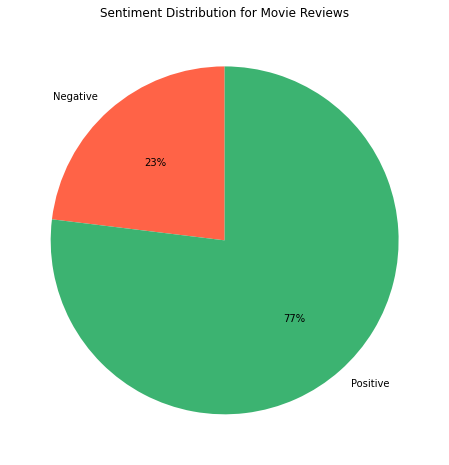

In [128]:
plt.figure(figsize = (8,8))
colors = ['tomato', 'mediumseagreen']
plt.title('Sentiment Distribution for Movie Reviews')
plt.pie(class_dist['Num_Reviews'], labels = class_dist['Sentiment'], autopct = '%1.0f%%', startangle = 90, colors = colors)
plt.show()

As seen above, it is evident that the class imbalance is quite large, with our data having more than triple the number of positive reviews over negative reviews. This isn't an ideal scenario as the performance of our model is dependent on its ability to distinguish between positive and negative reviews. Having this class imbalance will most likely result in a higher bias for positive reviews and cause it to perform poorly on identifying negative ones.  

One of the more straightforward solutions is to simply remove enough positive reviews so that the classes are then balanced. This will result in a lower number of total samples to train and test the model, but would largely benefit its ability to distinguish between classes. In addition, we can compile and aggregate additional reviews into our dataframe by importing the popular IMDB dataset commonly used on Kaggle. This will help make up a little of the data lost when we balance the classes. 

But first we'll map the star ratings into integer representations with:  
**0**: Negative sentiment  
**1**: Positive sentiment

In [129]:
def map_rating(rating):

    if type(rating) == str:
        if rating == 'negative':
            return 0 # Negative sentiment
        else:
            return 1 # Positive sentiment
    else:
        if rating <= 3:
            return 0 
        else:
            return 1 
        
imdb['Rating'] = imdb['Rating'].apply(map_rating)
imdb.rename(columns = {'Review':'review', 'Rating':'sentiment'}, inplace = True)
imdb.head()

,review,sentiment
0,I'll admit I raised an eyebrow when I saw that...,1
1,". . . The Riddle Maker, whose real name gets u...",1
2,"The Riddler(Paul Dano, spot-on. How did it tak...",1
4,"THE BATMAN (2022) *** Robert Pattinson, Zoe Kr...",1
6,"Always been a ""Batman"" fan as the D. C. legend...",1


Now we'll load up the popular IMDB dataset into a dataframe. This dataset has 25k reviews each for positive and negative sentiment.   
We'll only add the negative reviews into our existing dataframe so we don't have to remove as many positive reviews when we balance the classes.

In [130]:
imdb_50k = pd.read_csv('IMDB Dataset.csv')
imdb_50k.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [131]:
imdb_50k['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [132]:
imdb_50k['sentiment'] = imdb_50k['sentiment'].apply(map_rating)
imdb_50k['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [133]:
imdb_neg = imdb_50k[imdb_50k['sentiment'] == 0] # Extract negative reviews
imdb_neg['sentiment'].value_counts()

0    25000
Name: sentiment, dtype: int64

In [134]:
imdb = pd.concat([imdb, imdb_neg]).reset_index(drop = True) # Add the negative reviews to our existing dataframe
imdb['sentiment'].value_counts()

1    70474
0    46134
Name: sentiment, dtype: int64

Now that the data has been combined, one thing to look out for is the possibility for duplicate movie reviews, as it's entirely possible I've scraped reviews from identical movies present in the IMDB dataset. We'll just drop these from the dataframe:

In [135]:
print(len(imdb) - len(imdb.drop_duplicates()))

942


In [136]:
imdb.drop_duplicates(inplace = True)

We'll now remove the excess positive reviews to maintain balanced classes:

In [29]:
limit = imdb['sentiment'].value_counts()[0] - 1
pos = imdb[imdb['sentiment'] == 1].reset_index(drop = True)
neg = imdb[imdb['sentiment'] == 0]
new = pos.loc[:limit]
imdb = pd.concat([new, neg]).reset_index(drop = True)
imdb['sentiment'].value_counts()
# imdb.to_csv('imdb_clean_balanced.csv')

1    45814
0    45814
Name: sentiment, dtype: int64

### Cleaning Text Data

Since our data consists of movie reviews written by the public, a plethora of grammatical and punctuational errors can be expected in these user-submitted reviews. This text data will need to be cleaned and configured into an appropriate format that will improve the model's performance.  

We'll clean our text data using the following techniques:
- **Removing Stopwords**
- **Removing Punctuation**
- **Fixing Weird Spaces**
- **Removing HTML**
- **Convert to Lowercase**
- **Lemmatization**

In [137]:
stpwrds = set(stopwords.words('english'))

In [138]:
def remove_punc(text):
    # Replace sentence-ending punctuation with whitespace
    text = text.replace('.', ' ')
    text = text.replace('!', ' ')
    text = text.replace('?', ' ')
    # Replace commas and brackets with whitespace
    text = text.replace(',', ' ')
    text = text.replace('(', ' ')
    text = text.replace(')', ' ')
    # Replace word-dividing punctuation with whitespace to separate words
    text = text.replace('/', ' ')
    text = text.replace('-', ' ')
    # Remove the remaining punctuation from the reviews
    text = text.translate(str.maketrans('','', string.punctuation))
    return text

def fix_space(text):
    # Fix double spaces caused by replacing punctuation, and any other weird spaces
    text = text.split()
    text = " ".join(text)
    return text

def remove_html(text):
    # Remove html line breaks
    text = text.replace('<br />', '')
    # Remove all other possible html
    pattern = re.compile('<.*?>')
    text = pattern.sub(r'', text)
    return text

def remove_stopwords(text):
    # Remove common stopwords
    text = " ".join([string for string in str(text).split() if string not in stpwrds])
    return text

def lemmatize(text):
    # Convert words to their original lemma
    text = " ".join([WordNetLemmatizer().lemmatize(word) for word in text.split()])
    return text

def clean_text(text):
    text = text.lower()
    text = remove_html(text)
    text = remove_punc(text)
    text = fix_space(text)
    text = remove_stopwords(text)
    text = lemmatize(text)
    return text

imdb['clean_review'] = imdb['review'].apply(clean_text)

Let's pick a random movie review and see the difference between the original text and the cleaned text:  

Original:

In [252]:
imdb['review'][89601]

"One of My favorite movie of all time. An amazing mind boggling adventure that only Christopher Nolan could pull off. On top of that Hans Zimmer's score is absolutely exceptional and one of my all time favourites. A great story, too. Nolan just did it again and can score another great film. A true Masterpiece."

Cleaned:

In [253]:
imdb['clean_review'][89601]

'one favorite movie time amazing mind boggling adventure christopher nolan could pull top han zimmer score absolutely exceptional one time favourite great story nolan score another great film true masterpiece'

### Training the Model with XGBoost  

We'll separate the data into 80% training and 20% testing sets:

In [36]:
X_train, X_test, y_train, y_test = train_test_split(imdb['clean_review'], imdb['sentiment'],
                                                   train_size = 0.8, random_state = 21)

In [37]:
X_train.shape

(73302,)

In [38]:
X_test.shape

(18326,)

Our text data needs to be converted into numerical data in order to be understood by the machine learning model, so we'll use CountVectorizer to transform our data into a matrix of token counts:

In [39]:
word_vec = CountVectorizer()
X_train = word_vec.fit_transform(X_train)
X_test = word_vec.transform(X_test)

In [40]:
xgmodel = XGBClassifier(max_depth = 8, eta = 0.2, objective = 'binary:logistic', n_estimators = 600,
                       subsample = 1, eval_metric = 'auc')
xgmodel.fit(X_train, y_train)

C:\Users\denze\Anaconda3\envs\tf2_cpu\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.2, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.200000003, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

### Evaluate Model Performance

In [41]:
pred = xgmodel.predict(X_test)
accuracy = metrics.accuracy_score(y_test, pred)
accuracy

0.935010367783477

In [42]:
print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      9180
           1       0.93      0.94      0.94      9146

    accuracy                           0.94     18326
   macro avg       0.94      0.94      0.94     18326
weighted avg       0.94      0.94      0.94     18326



In [43]:
confusion = metrics.confusion_matrix(y_test, pred)
confusion

array([[8533,  647],
       [ 544, 8602]], dtype=int64)

In [44]:
pickle.dump(xgmodel, open('xgmodel.pkl', 'wb'))
pickle.dump(word_vec, open('word_vec.pkl', 'wb'))